# Predicting electricity carbon intensity at a given time and place (test = Germany)

## Import libraries and modules

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers, models, layers, Sequential
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import joblib
import pickle

2025-03-22 11:22:48.910319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 11:22:48.945747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 11:22:49.322435: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-22 11:22:49.531425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742638969.716613   37698 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742638969.76

In [2]:
# Installing faspapi unicorn
!pip install fastapi uvicorn
!pip install --upgrade typing_extensions
!pip install tensorflow
!pip install scikeras

## 1. Extract hourly carbon intensity and elecricity sources data from Electricity Maps API

In [194]:
"""
get extended carbon intensity data (15 jan 2025 to 15 mar 2025) by querying consecutive 24-hour windows
- loops over the overall period (15 jan to 15 mar 2025), making separate API calls for each 24-hour interval.
- concatenates the results into a single dataframe.
- drops unwanted columns.
"""

def get_carbon_intensity_history(start_str, end_str, zone="DE", resolution="hour"):
    base_url = "https://api.electricitymap.org/v3/carbon-intensity/history"
    url = f"{base_url}?zone={zone}&start={start_str}&end={end_str}&resolution={resolution}"
    response = requests.get(url, headers={"auth-token": "covOsi4VsXc8mIdsxumr"})
    data = response.json()
    return pd.DataFrame(data.get("history", []))

# Define the overall period: from 15 January 2025 00:00:00.000Z to 15 March 2025 (full day)
overall_start = datetime.strptime("2025-01-15T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")
# To include all of 15 March, we set the end time to 16 March 2025 00:00:00.000Z
overall_end   = datetime.strptime("2025-03-16T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")

dfs = []
current_start = overall_start

while current_start < overall_end:
    current_end = current_start + timedelta(hours=24)
    if current_end > overall_end:
        current_end = overall_end
    # Format dates in the required ISO format with milliseconds
    start_str = current_start.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    end_str = current_end.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    df_temp = get_carbon_intensity_history(start_str, end_str)
    dfs.append(df_temp)
    current_start = current_end

df_de_carbon_intensity = pd.concat(dfs, ignore_index=True)

# Drop unwanted columns
unwanted_cols = ["updatedAt", "createdAt", "emissionFactorType", "isEstimated", "estimationMethod"]
df_de_carbon_intensity = df_de_carbon_intensity.drop(columns=unwanted_cols, errors="ignore")

print("Total carbon intensity data shape:", df_de_carbon_intensity.shape)


Total carbon intensity data shape: (1440, 3)


In [195]:
"""
get extended electricity sources data (15 jan 2025 to 15 mar 2025) by querying consecutive 24-hour windows
- loops over the overall period (15 jan to 15 mar 2025), making separate API calls for each 24-hour interval.
- concatenates the results into a single dataframe.
- drops unwanted columns: updatedAt, createdAt.
- assigns the result to df_de_electricity_sources.
"""

def get_power_breakdown_history(start_str, end_str, zone="DE", resolution="hour"):
    base_url = "https://api.electricitymap.org/v3/power-breakdown/history"
    url = f"{base_url}?zone={zone}&start={start_str}&end={end_str}&resolution={resolution}"
    response = requests.get(url, headers={"auth-token": "covOsi4VsXc8mIdsxumr"})
    data = response.json()
    # flatten the nested json
    df = pd.json_normalize(data.get("history", []))
    return df

# overall period: 15 jan 2025 00:00:00.000z to include full day 15 mar 2025, set end to 16 mar 2025 00:00:00.000z
overall_start = datetime.strptime("2025-01-15T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")
overall_end   = datetime.strptime("2025-03-16T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")

dfs = []
current_start = overall_start
while current_start < overall_end:
    current_end = current_start + timedelta(hours=24)
    if current_end > overall_end:
        current_end = overall_end
    start_str = current_start.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    end_str = current_end.strftime("%Y-%m-%dT%H:%M:%S.%fZ")
    df_temp = get_power_breakdown_history(start_str, end_str)
    dfs.append(df_temp)
    current_start = current_end

df_full_power = pd.concat(dfs, ignore_index=True)
# select only the desired keys from powerConsumptionBreakdown
e_consumption_types = [
    "powerConsumptionBreakdown.nuclear",
    "powerConsumptionBreakdown.geothermal",
    "powerConsumptionBreakdown.biomass",
    "powerConsumptionBreakdown.coal",
    "powerConsumptionBreakdown.wind",
    "powerConsumptionBreakdown.solar",
    "powerConsumptionBreakdown.hydro",
    "powerConsumptionBreakdown.gas",
    "powerConsumptionBreakdown.oil"
]
# keep datetime and desired keys only
df_de_electricity_sources = df_full_power[["datetime"] + e_consumption_types].copy()

print("electricity sources data shape:", df_de_electricity_sources.shape)

electricity sources data shape: (1440, 10)


## 2. Merge datasets on datetime (time-consistency)

In [2]:
"""
merge datasets & export csv
- merges df_de_carbon_intensity and df_de_electricity_sources on 'datetime'.
- exports the merged dataframe to a csv file.
"""

# merge the two dataframes on datetime (inner join)
df_de_merged = pd.merge(df_de_carbon_intensity, df_de_electricity_sources, on="datetime", suffixes=("_carbon", "_electricity"))

# export merged dataframe to csv
df_de_merged.to_csv("df_de_merged.csv", index=False)
print("merged data exported to 'df_de_merged.csv'")


NameError: name 'df_de_carbon_intensity' is not defined

## 3. Basic info

In [3]:
"""
basic info
- prints basic characteristics of the merged dataset.
"""
df_de_merged = pd.read_csv("/root/code/senetan/MEGA_project/raw_data/df_de_merged.csv")

print("shape:", df_de_merged.shape)
print("columns:", df_de_merged.columns.tolist())
print("df_de_merged data types:")
print(df_de_merged.dtypes)


shape: (86400, 12)
columns: ['zone', 'carbonIntensity', 'datetime', 'powerConsumptionBreakdown.nuclear', 'powerConsumptionBreakdown.geothermal', 'powerConsumptionBreakdown.biomass', 'powerConsumptionBreakdown.coal', 'powerConsumptionBreakdown.wind', 'powerConsumptionBreakdown.solar', 'powerConsumptionBreakdown.hydro', 'powerConsumptionBreakdown.gas', 'powerConsumptionBreakdown.oil']
df_de_merged data types:
zone                                    object
carbonIntensity                          int64
datetime                                object
powerConsumptionBreakdown.nuclear        int64
powerConsumptionBreakdown.geothermal     int64
powerConsumptionBreakdown.biomass        int64
powerConsumptionBreakdown.coal           int64
powerConsumptionBreakdown.wind           int64
powerConsumptionBreakdown.solar          int64
powerConsumptionBreakdown.hydro          int64
powerConsumptionBreakdown.gas            int64
powerConsumptionBreakdown.oil            int64
dtype: object


In [4]:
nan_counts = df_de_merged.isnull().sum()
print(nan_counts)

zone                                    0
carbonIntensity                         0
datetime                                0
powerConsumptionBreakdown.nuclear       0
powerConsumptionBreakdown.geothermal    0
powerConsumptionBreakdown.biomass       0
powerConsumptionBreakdown.coal          0
powerConsumptionBreakdown.wind          0
powerConsumptionBreakdown.solar         0
powerConsumptionBreakdown.hydro         0
powerConsumptionBreakdown.gas           0
powerConsumptionBreakdown.oil           0
dtype: int64


In [5]:
"""
ensures that df_de_merged is sorted in ascending order by 'datetime'
"""

# ensure the datetime column is in datetime format
df_de_merged['datetime'] = pd.to_datetime(df_de_merged['datetime'])

# sort the dataframe chronologically and reset the index
df_de_merged = df_de_merged.sort_values(by='datetime', ascending=True).reset_index(drop=True)

#print("df_de_merged sorted in chronological order:")
#print(df_de_merged.head())


## 4. Feature preprocessing

In [6]:

"""
compress df_de_merged
- downcasts numeric columns (int64/float64) to lower memory types, except datetime columns.
"""

def compress_df(df):
    df_compressed = df.copy()
    for col in df_compressed.columns:
        # skip datetime columns
        if pd.api.types.is_datetime64_any_dtype(df_compressed[col]):
            continue
        if pd.api.types.is_numeric_dtype(df_compressed[col]):
            if pd.api.types.is_integer_dtype(df_compressed[col]):
                df_compressed[col] = pd.to_numeric(df_compressed[col], downcast='integer')
            elif pd.api.types.is_float_dtype(df_compressed[col]):
                df_compressed[col] = pd.to_numeric(df_compressed[col], downcast='float')
    return df_compressed

df_de_merged = compress_df(df_de_merged)
print("compressed dtypes:")
print(df_de_merged.dtypes)


compressed dtypes:
zone                                                 object
carbonIntensity                                       int16
datetime                                datetime64[ns, UTC]
powerConsumptionBreakdown.nuclear                     int16
powerConsumptionBreakdown.geothermal                   int8
powerConsumptionBreakdown.biomass                     int16
powerConsumptionBreakdown.coal                        int16
powerConsumptionBreakdown.wind                        int16
powerConsumptionBreakdown.solar                       int16
powerConsumptionBreakdown.hydro                       int16
powerConsumptionBreakdown.gas                         int16
powerConsumptionBreakdown.oil                         int16
dtype: object


In [7]:
"""
cell: feature extraction and normalization (stateless preprocessor)
- extracts time features (cyclical and one-hot encoded),
- extracts energy features,
- computes relative percentages for energy sources (each divided by the row sum),
- returns a fixed-order dataframe.
"""

def extract_time_energy_features(x):
    x = x.copy()
    # time features
    x['datetime'] = pd.to_datetime(x['datetime'])
    x['hour'] = x['datetime'].dt.hour
    x['weekday'] = x['datetime'].dt.weekday
    x['hour_sin'] = np.sin(2 * np.pi * x['hour'] / 24)
    x['hour_cos'] = np.cos(2 * np.pi * x['hour'] / 24)
    x['weekday_sin'] = np.sin(2 * np.pi * x['weekday'] / 7)
    x['weekday_cos'] = np.cos(2 * np.pi * x['weekday'] / 7)
    # one-hot encoding for time
    hour_dummies = pd.get_dummies(x['hour'], prefix='hour')
    weekday_dummies = pd.get_dummies(x['weekday'], prefix='weekday')
    expected_hour_cols = [f'hour_{i}' for i in range(24)]
    expected_weekday_cols = [f'weekday_{i}' for i in range(7)]
    hour_dummies = hour_dummies.reindex(columns=expected_hour_cols, fill_value=0)
    weekday_dummies = weekday_dummies.reindex(columns=expected_weekday_cols, fill_value=0)
    time_order = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'] + expected_hour_cols + expected_weekday_cols
    time_features = pd.concat([x[['hour_sin','hour_cos','weekday_sin','weekday_cos']], hour_dummies, weekday_dummies], axis=1)
    time_features = time_features[time_order]

    # energy features: from df_de_electricity_sources, keys assumed to be in x
    energy_cols = [
        "powerConsumptionBreakdown.nuclear",
        "powerConsumptionBreakdown.geothermal",
        "powerConsumptionBreakdown.biomass",
        "powerConsumptionBreakdown.coal",
        "powerConsumptionBreakdown.wind",
        "powerConsumptionBreakdown.solar",
        "powerConsumptionBreakdown.hydro",
        "powerConsumptionBreakdown.gas",
        "powerConsumptionBreakdown.oil"
    ]
    energy_features = x[energy_cols].copy()
    # compute the row-wise sum for energy sources
    energy_sum = energy_features.sum(axis=1).replace(0, np.nan)
    # compute relative percentage (0 to 1)
    energy_relative = energy_features.div(energy_sum, axis=0).fillna(0)

    final_order = time_order + energy_cols
    final_features = pd.concat([time_features, energy_relative], axis=1)
    final_features = final_features[final_order]
    return final_features

# pure transformer without state using function transformer
feature_transformer = FunctionTransformer(extract_time_energy_features, validate=False)

# build pipeline (stateless preprocessor)
features_pipeline = Pipeline([
    ('feature_extraction_and_normalization', feature_transformer)
])

# test on the merged dataframe (df_de_merged should have both 'datetime' and energy columns)
df_processed = features_pipeline.transform(df_de_merged)
print("preprocessed features shape:", df_processed.shape)


preprocessed features shape: (86400, 44)


## 5. Train test split

In [8]:
# Chronological split
split_ratio = 0.20
test_length = int(len(df_de_merged) * split_ratio)
val_length = int((len(df_de_merged) - test_length) * split_ratio)
train_length = len(df_de_merged) - val_length - test_length

df_train = df_de_merged.iloc[:train_length, :].copy()
df_val   = df_de_merged.iloc[train_length: train_length + val_length, :].copy()
df_test  = df_de_merged.iloc[train_length + val_length:, :].copy()

print("train shape:", df_train.shape)
print("validation shape:", df_val.shape)
print("test shape:", df_test.shape)

# Define target variables
y_train = df_train['carbonIntensity']
y_val   = df_val['carbonIntensity']
y_test  = df_test['carbonIntensity']


train shape: (55296, 12)
validation shape: (13824, 12)
test shape: (17280, 12)


In [9]:
# define target scaler and transform target variables
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = target_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = target_scaler.transform(y_test.values.reshape(-1, 1))

# preprocess the data splits using the state-less features pipeline
X_train_processed = features_pipeline.transform(df_train)
X_val_processed = features_pipeline.transform(df_val)
X_test_processed = features_pipeline.transform(df_test)

print("processed feature shapes:")
print("X_train_processed:", X_train_processed.shape)
print("X_val_processed:", X_val_processed.shape)
print("X_test_processed:", X_test_processed.shape)


processed feature shapes:
X_train_processed: (55296, 44)
X_val_processed: (13824, 44)
X_test_processed: (17280, 44)


## 6. Build and train the model

In [10]:
"""
- initializes a deep neural network.
"""

# initialize model
def initialize_model(input_shape: tuple):
    reg = regularizers.l1_l2(l1=0.005)
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="linear"))
    print("✅ model initialized")
    return model

input_shape = (X_train_processed.shape[1],)
model = initialize_model(input_shape)
model.summary()


✅ model initialized


2025-03-21 16:06:32.944771: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,201 (39.85 KB)

 Trainable params: 9,901 (38.68 KB)

 Non-trainable params: 300 (1.17 KB)

In [11]:
# compile model
learning_rate = 0.0005
batch_size = 256
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

# early stopping callback
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# train on scaled targets
history = model.fit(
    X_train_processed,
    y_train_scaled,
    validation_data=(X_val_processed, y_val_scaled),
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)
model_and_pipeline = {
    'features_pipeline': features_pipeline,
    'target_scaler': target_scaler
}
# export the model
model.save('/root/code/senetan/MEGA_project/models/MEGA_model.h5')

joblib.dump(features_pipeline, '/root/code/senetan/MEGA_project/models/features_pipeline.pkl')
joblib.dump(target_scaler, '/root/code/senetan/MEGA_project/models/target_scaler.pkl')

Epoch 1/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.6737 - mae: 0.6238 - val_loss: 1.4724 - val_mae: 0.5209
Epoch 2/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0892 - mae: 0.3220 - val_loss: 0.8803 - val_mae: 0.4940
Epoch 3/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6507 - mae: 0.2530 - val_loss: 0.5986 - val_mae: 0.3937
Epoch 4/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4495 - mae: 0.2037 - val_loss: 0.4626 - val_mae: 0.3874
Epoch 5/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3044 - mae: 0.1656 - val_loss: 0.2864 - val_mae: 0.2884
Epoch 6/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2029 - mae: 0.1371 - val_loss: 0.1686 - val_mae: 0.1933
Epoch 7/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1334 - mae: 0.1138 - val_loss: 0.1417 - val_mae: 0.2327
Epoch 8/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0871 - mae: 0.0944 - val_loss: 0.1215 - val_mae: 0.2396
Epoch 9/100
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

['/root/code/senetan/MEGA_project/models/target_scaler.pkl']

## 7. Predict and evaluate the model

In [13]:
# evaluate in scaled units
val_metrics_scaled = model.evaluate(X_val_processed, y_val_scaled, verbose=0)
test_metrics_scaled = model.evaluate(X_test_processed, y_test_scaled, verbose=0)
print("mae val (scaled):", round(val_metrics_scaled[1], 2))
print("mae test (scaled):", round(test_metrics_scaled[1], 2))

# predict on test set (reverse scaled to find back the right, unscaled units)
y_pred_scaled = model.predict(X_test_processed)
# inverse transform predictions and test targets to original gco2eq/kwh units
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test_scaled)

mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
print("mae test (gco2eq/kwh):", round(mae, 2))
print("mse test (gco2eq/kwh):", round(mse, 2))


mae val (scaled): 0.21
mae test (scaled): 0.05
540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mae test (gco2eq/kwh): 12.69
mse test (gco2eq/kwh): 203.97


In [14]:
# compute the average carbon intensity over the period
mean_carbon = df_de_merged['carbonIntensity'].mean()
print("mean carbon intensity (gco2eq/kwh):", round(mean_carbon, 2))

# assume mae is the test MAE in gco2eq/kwh (e.g., 42.51)
# compute the percentage error
percentage_error = (mae / mean_carbon) * 100
print("mae test as percentage of average carbon intensity:", round(percentage_error, 2), "%")
print("Ok the mae is around 11% of the mean carbon intensity, not great but not too bad")

mean carbon intensity (gco2eq/kwh): 383.0
mae test as percentage of average carbon intensity: 3.31 %
Ok the mae is around 11% of the mean carbon intensity, not great but not too bad


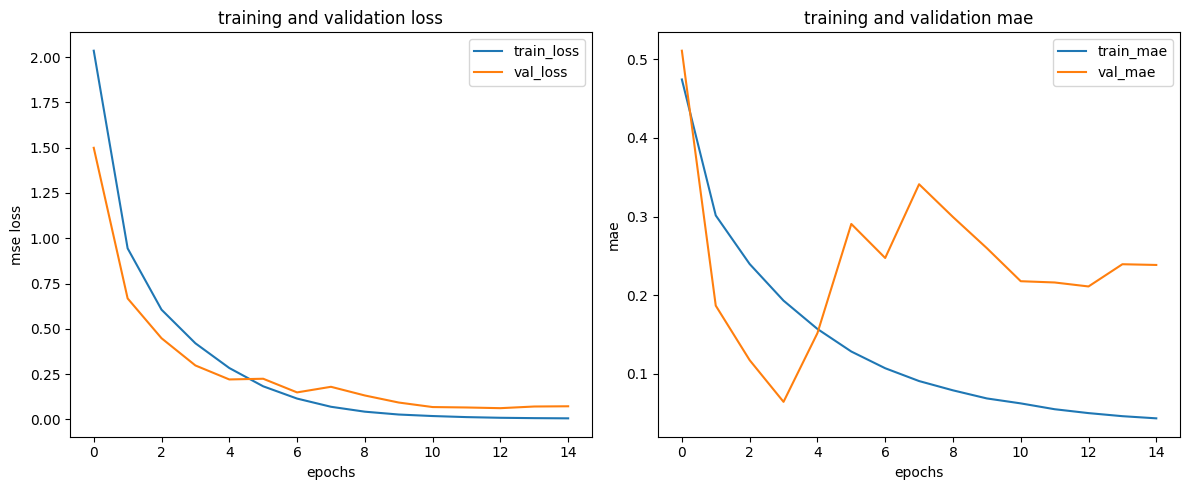

In [15]:
# Plot training history: loss and MAE

plt.figure(figsize=(12, 5))

# left: training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('mse loss')
plt.title('training and validation loss')
plt.legend()

# right: training and validation mae
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.title('training and validation mae')
plt.legend()

plt.tight_layout()
plt.show()


y_pred min: 440.30087 max: 459.686
y_test_original min: 437.0 max: 459.0


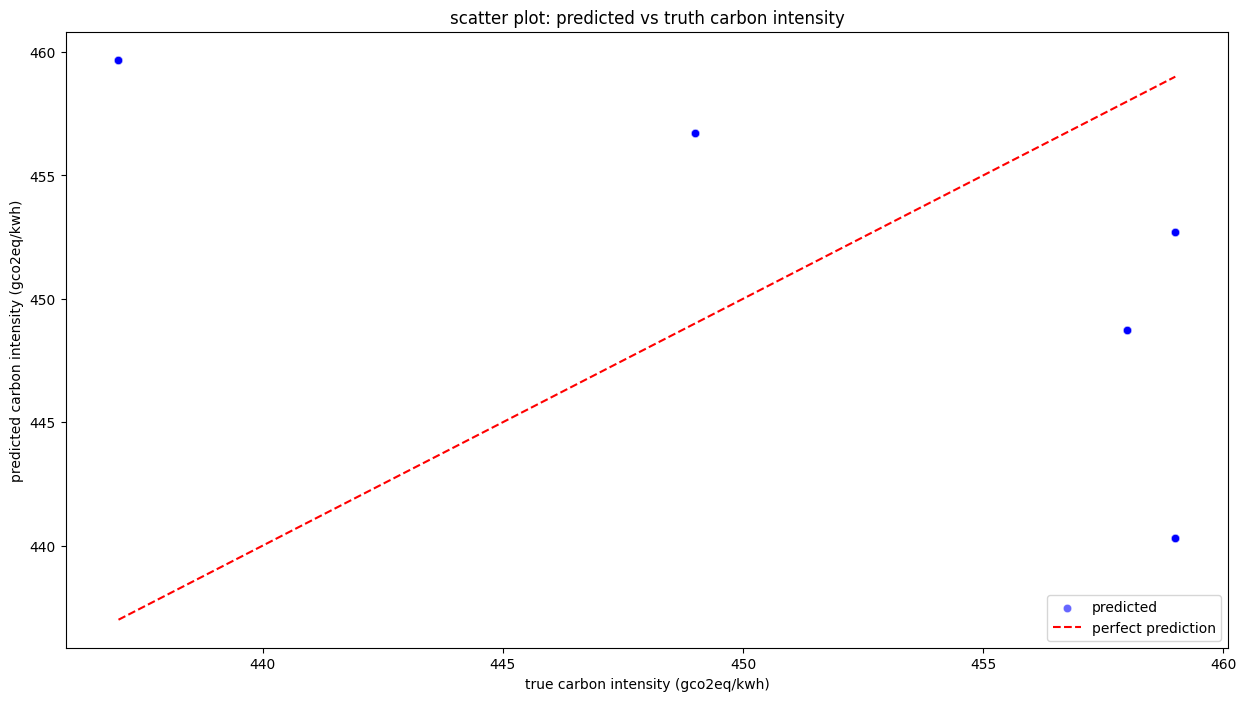

In [16]:
#visualization of predictions

# print the range of predictions and true values
print("y_pred min:", np.min(y_pred), "max:", np.max(y_pred))
print("y_test_original min:", np.min(y_test_original), "max:", np.max(y_test_original))

plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_test_original.flatten(), y=y_pred.flatten(), color='blue', alpha=0.6, label='predicted')

plt.xlabel("true carbon intensity (gco2eq/kwh)")
plt.ylabel("predicted carbon intensity (gco2eq/kwh)")
plt.title("scatter plot: predicted vs truth carbon intensity")

# overlay a perfect prediction line
min_val = np.min(y_test_original)
max_val = np.max(y_test_original)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="perfect prediction")
plt.legend()

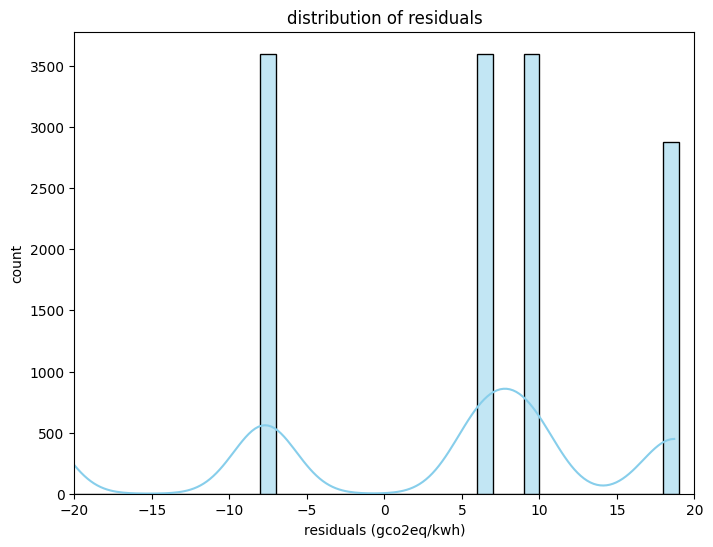

In [17]:
residuals = y_test_original.flatten() - y_pred.flatten()
# plot residuals distribution
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=np.arange(-20, 20, 1), kde=True, color="skyblue")
plt.xlim(-20, 20)
plt.xlabel("residuals (gco2eq/kwh)")
plt.ylabel("count")
plt.title("distribution of residuals")
plt.show()

In [18]:
# example input for a specific datetime with sample energy mix values
sample_input = {
    "datetime": "2025-04-12T12:00:00.000Z",
    "powerConsumptionBreakdown.nuclear": 50,
    "powerConsumptionBreakdown.geothermal": 10,
    "powerConsumptionBreakdown.biomass": 100,
    "powerConsumptionBreakdown.coal": 200,
    "powerConsumptionBreakdown.wind": 300,
    "powerConsumptionBreakdown.solar": 20,
    "powerConsumptionBreakdown.hydro": 400,
    "powerConsumptionBreakdown.gas": 150,
    "powerConsumptionBreakdown.oil": 30
}

sample_df = pd.DataFrame([sample_input])
sample_features = features_pipeline.transform(sample_df)
sample_pred_scaled = model.predict(sample_features)
sample_pred = target_scaler.inverse_transform(sample_pred_scaled)
print("predicted carbon intensity for 12 april 2025 at 12:00:", sample_pred[0][0], "gco2eq/kwh")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
predicted carbon intensity for 12 april 2025 at 12:00: 178.04585 gco2eq/kwh


## 8. FastAPI draft code

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn

app = FastAPI()

class PredictionInput(BaseModel):
    datetime: str
    powerConsumptionBreakdown_nuclear: float
    powerConsumptionBreakdown_geothermal: float
    powerConsumptionBreakdown_biomass: float
    powerConsumptionBreakdown_coal: float
    powerConsumptionBreakdown_wind: float
    powerConsumptionBreakdown_solar: float
    powerConsumptionBreakdown_hydro: float
    powerConsumptionBreakdown_gas: float
    powerConsumptionBreakdown_oil: float

@app.post("/predict")
def predict(input_data: PredictionInput):
    data = input_data.dict()
    # rename keys to match expected columns
    mapping = {
        "powerConsumptionBreakdown_nuclear": "powerConsumptionBreakdown.nuclear",
        "powerConsumptionBreakdown_geothermal": "powerConsumptionBreakdown.geothermal",
        "powerConsumptionBreakdown_biomass": "powerConsumptionBreakdown.biomass",
        "powerConsumptionBreakdown_coal": "powerConsumptionBreakdown.coal",
        "powerConsumptionBreakdown_wind": "powerConsumptionBreakdown.wind",
        "powerConsumptionBreakdown_solar": "powerConsumptionBreakdown.solar",
        "powerConsumptionBreakdown_hydro": "powerConsumptionBreakdown.hydro",
        "powerConsumptionBreakdown_gas": "powerConsumptionBreakdown.gas",
        "powerConsumptionBreakdown_oil": "powerConsumptionBreakdown.oil"
    }
    for k, v in mapping.items():
        data[v] = data.pop(k)
    sample_df = pd.DataFrame([data])
    sample_features = features_pipeline.transform(sample_df)
    pred_scaled = model.predict(sample_features)
    pred = target_scaler.inverse_transform(pred_scaled)
    return {"predicted_carbon_intensity": pred[0][0]}

# run the app with: uvicorn.run(app, host="0.0.0.0", port=8000)


/root/.pyenv/versions/3.10.6/lib/python3.10/ast.py:252: RuntimeWarning: coroutine 'Server.serve' was never awaited
  for field in node._fields:


RuntimeError: asyncio.run() cannot be called from a running event loop